In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data preprocessing
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [3]:
# Load the Food101 dataset
train_dataset = datasets.Food101(root="./data", split="train", transform=data_transforms["train"], download=True)
val_dataset = datasets.Food101(root="./data", split="test", transform=data_transforms["val"], download=True)

In [4]:
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8),
    "val": DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8),
}

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
class_names = train_dataset.classes

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 101)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = CustomCNN().to(device)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

# Save the model
torch.save(model.state_dict(), "custom_cnn_food101.pth")
print("Model saved!")

Epoch 1/10
----------


100%|██████████| 592/592 [00:51<00:00, 11.46it/s]


train Loss: 4.5043 Acc: 0.0225


100%|██████████| 198/198 [00:10<00:00, 19.11it/s]


val Loss: 4.2147 Acc: 0.0576

Epoch 2/10
----------


100%|██████████| 592/592 [00:48<00:00, 12.14it/s]


train Loss: 4.1592 Acc: 0.0680


100%|██████████| 198/198 [00:10<00:00, 18.53it/s]


val Loss: 3.9480 Acc: 0.0966

Epoch 3/10
----------


100%|██████████| 592/592 [00:49<00:00, 11.90it/s]


train Loss: 3.9546 Acc: 0.1000


100%|██████████| 198/198 [00:11<00:00, 17.84it/s]


val Loss: 3.7504 Acc: 0.1287

Epoch 4/10
----------


100%|██████████| 592/592 [00:51<00:00, 11.59it/s]


train Loss: 3.8149 Acc: 0.1221


100%|██████████| 198/198 [00:11<00:00, 16.83it/s]


val Loss: 3.4764 Acc: 0.1752

Epoch 5/10
----------


100%|██████████| 592/592 [00:50<00:00, 11.66it/s]


train Loss: 3.7057 Acc: 0.1422


100%|██████████| 198/198 [00:11<00:00, 16.94it/s]


val Loss: 3.4137 Acc: 0.1798

Epoch 6/10
----------


100%|██████████| 592/592 [00:50<00:00, 11.75it/s]


train Loss: 3.6040 Acc: 0.1569


100%|██████████| 198/198 [00:12<00:00, 15.85it/s]


val Loss: 3.2521 Acc: 0.2120

Epoch 7/10
----------


100%|██████████| 592/592 [00:52<00:00, 11.37it/s]


train Loss: 3.5249 Acc: 0.1730


100%|██████████| 198/198 [00:11<00:00, 16.50it/s]


val Loss: 3.1605 Acc: 0.2308

Epoch 8/10
----------


100%|██████████| 592/592 [00:51<00:00, 11.40it/s]


train Loss: 3.4556 Acc: 0.1863


100%|██████████| 198/198 [00:12<00:00, 16.31it/s]


val Loss: 3.1699 Acc: 0.2288

Epoch 9/10
----------


100%|██████████| 592/592 [00:50<00:00, 11.70it/s]


train Loss: 3.3848 Acc: 0.2000


100%|██████████| 198/198 [00:11<00:00, 17.11it/s]


val Loss: 3.1287 Acc: 0.2393

Epoch 10/10
----------


100%|██████████| 592/592 [00:51<00:00, 11.49it/s]


train Loss: 3.3243 Acc: 0.2109


100%|██████████| 198/198 [00:11<00:00, 17.12it/s]


val Loss: 2.9696 Acc: 0.2680

Best val Acc: 0.2680
Model saved!


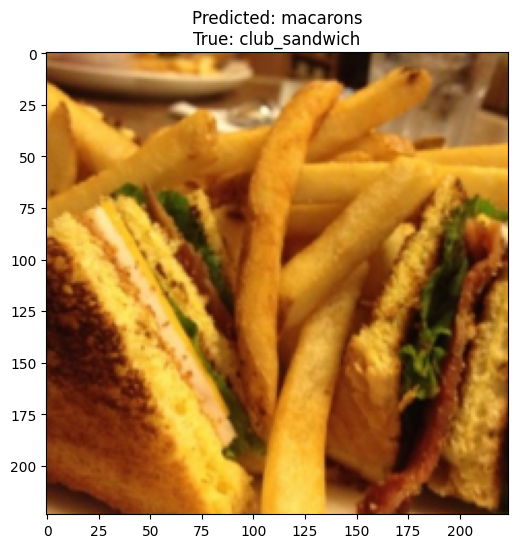

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to visualize the image and prediction
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update plots

# Load a random image from the validation dataset
def demo(model):
    model.eval()
    with torch.no_grad():
        # Randomly pick a sample from the validation dataset
        inputs, labels = next(iter(DataLoader(val_dataset, batch_size=1, shuffle=True)))
        inputs, labels = inputs.to(device), labels.to(device)

        # Make predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Display the image with its predicted label
        plt.figure(figsize=(6, 6))
        imshow(inputs.cpu().data[0], title=f"Predicted: {class_names[preds[0]]}\nTrue: {class_names[labels[0]]}")
        plt.show()

# Run the demo
demo(model)